# Gyre circulation model

This model computes the gyre circulation based on a Sverdrup solution for
the basin interior and a Stommel (bottom drag) or Munk (lateral friction)
boundary layer solution at the western or eastern boundary of the basin
to close the gyre. The model forcing, i.e. the wind stress, is variable.
At the end the model produces a figure of the forcing and the output.
The basin geometry has been set to a rectangular basin of the rough
dimensions of the North Pacific.
(equations from Vallis, 2006)

Model implementation by S. Yang (McGill University, Montreal) 

Code adapted for "Introduction to Physical Oceanography", ETH Zurich,
A. Haumann, 2014

translated to Python by E. E. Köhn, 2019

## Load packages

In [1]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
import copy

## Function to compute circulation (do not change)

In [16]:
def plot_model(western_0,eastern_0,bottom_drag,lat_frict,drag_coef):
    x_0       = 0.                                 # Startpoint on x-axis [m]
    y_0       = 0.                                 # Startpoint on y-axis [m]
    L_x       = 8000.*10**3                        # zonal extent [m]
    L_y       = 4000.*10**3                        # meridional extent [m]
    np_x      = 800                                # Number of grid cells in x-direction
    np_y      = 400                                # Number of grid cells in y-direction
    
    viscosity = 1.6*10**(5)                        # Viscosity [m2 s-1]

    rho       = 1030.                              # density [kg/m3]
    lat       = 30.                                # Latitude [deg N]
    R_E       = 6370.*10**3                        # Earth radius [m];
    omega     = 2.*np.pi/86164.                    # Earth rotational frequency [1/s]

    dx        = L_x/np_x                           # zonal grid spacing [m]
    dy        = L_y/np_y                           # meridional grid spacing [m]
    xdum      = np.arange(x_0+dx/2,L_x-dx/2+dx,dx)
    x         = np.repeat(xdum[np.newaxis,:],np_y,axis=0)          # zonal coordinates [m]
    ydum      = np.arange(y_0+dy/2,L_y-dy/2+dy,dy)
    y         = np.repeat(ydum[:,np.newaxis],np_x,axis=1)          # meridional coordinates [m]
    xdum_ext  = np.arange(x_0-dx/2,L_x+dx/2+dx,dx)
    x_ext     = np.repeat(xdum_ext[np.newaxis,:],np_y+2,axis=0)    # zonal coordinates [m]
    ydum_ext  = np.arange(y_0-dy/2,L_y+dy/2+dy,dy)
    y_ext     = np.repeat(ydum_ext[:,np.newaxis],np_x+2,axis=1)    # meridional coordinates [m]
    
    tau_0     = 0.08                                               # Amplitude of the windstress [N/m2]
    tau_x     = -np.cos(np.pi*y_ext/L_y)                           # zonal wind stress [N/m2]
    #tau_x     = -np.cos(2.*np.pi*y_ext/L_y);                      # zonal wind stress [N/m2] two gyres
    tau_y     = np.zeros_like(x_ext)                               # meridional wind stress [N/m2]    
        
    # rotational force (beta):
    rot_force=2.*omega*np.cos(lat*np.pi/180.)*1./R_E      #[1/ms]
    
    # curl of wind stress:
    dtau_x=tau_x[1:,:]-tau_x[:-1,:]   # meridional gradient of tau_x
    dtau_x=(dtau_x[1:,:]+dtau_x[:-1,:])/2.  # convert tau_y center
    dtau_x = np.delete(dtau_x,0,axis=1)
    dtau_x = np.delete(dtau_x,-1,axis=1)
    dtau_y=tau_y[:,1:]-tau_y[:,:-1]    # zonal gradient of tau_y
    dtau_y=(dtau_y[:,1:]+dtau_y[:,:-1])/2.   # convert tau_x center
    dtau_y = np.delete(dtau_y,0,axis=0)
    dtau_y = np.delete(dtau_y,-1,axis=0)
    tau_curl=(dtau_y/dx-dtau_x/dy);
    
    # Sverdrup balance
    if eastern_0 and not western_0:
        western_bl  = True                  # Frictional boundary layer will be on the western side if "true" (else "false")
        eastern_bl  = False                 # Frictional boundary layer will be on the eastern side if "true" (else "false")
        C1=L_x
    elif western_0 and not eastern_0:
        western_bl  = False                 # Frictional boundary layer will be on the western side if "true" (else "false")
        eastern_bl  = True                  # Frictional boundary layer will be on the eastern side if "true" (else "false")
        C1=0
    elif not western_0 and not eastern_0:
        raise ValueError('Boundary condition required. Set either "eastern_0" or "western_0" to "true"')
    elif western_0 and eastern_0:
        western_bl  = False                 # Frictional boundary layer will be on the western side if "true" (else "false")
        eastern_bl  = False                 # Frictional boundary layer will be on the eastern side if "true" (else "false")
        warnings.warn('Both sides vanish to zero equally.')
        C1=L_x
    
    psi_interior=tau_0/rot_force/rho*tau_curl*(C1-x)
    
    
    # Stommel BL: bottom drag
    if western_bl:
        phi_stommel=-psi_interior*np.exp(-x*rot_force/drag_coef)
    elif eastern_bl:
        phi_stommel=-psi_interior*np.fliplr(np.exp(-x*rot_force/drag_coef))
    
    # Munk BL: lateral friction (using no-slip conditions)
    eps_m=(viscosity/rot_force)**(1./3.)
    if western_bl:
        phi_munk=-psi_interior*np.exp(-x/(2.*eps_m))*(np.cos(((3.**(1./2.))*x)/(2.*eps_m))+(1./(3**(1./2.)))*np.sin(((3**(1./2.))*x)/(2.*eps_m)))
    elif eastern_bl:
        phi_munk=-psi_interior*np.fliplr(np.exp(-x/(2.*eps_m))*(np.cos(((3.**(1./2.))*x)/(2.*eps_m))+(1./(3.**(1./2.)))*np.sin(((3.**(1./2.))*x)/(2.*eps_m))))
    
    
    # Apply BL correction:
    if not bottom_drag and not lat_frict:
        psi=psi_interior
    elif bottom_drag and not lat_frict:
        if western_0 and eastern_0:
            raise ValueError('No frictional boundary layer. Set either "eastern_0" or "western_0" to "true" but not both')
        psi=psi_interior+phi_stommel
    elif not bottom_drag and lat_frict:
        if western_0 and eastern_0:
            raise ValueError('No frictional boundary layer. Set either "eastern_0" or "western_0" to "true" but not both')
        psi=psi_interior+phi_munk
    elif bottom_drag and lat_frict:
        if western_0 and eastern_0:
            raise ValueError('No frictional boundary layer. Set either "eastern_0" or "western_0" to "true" but not both')
        psi=psi_interior+phi_stommel+phi_munk
    
    if not western_bl and not eastern_bl:
        psi=psi_interior-psi_interior*np.exp(-x*rot_force/1)


    # Calculate u & v:
    dpsi_V=psi[1:,:]-psi[:-1,:]
    dy_V=y[1:,:]-y[:-1,:]
    dpsi_U=psi[:,1:]-psi[:,:-1]
    dx_U=x[:,1:]-x[:,:-1]
    
    V=-dpsi_U/dx_U
    V=(V[:,1:]+V[:,:-1])/2
    V = np.hstack((np.zeros((V.shape[0],1))+np.NaN,V,np.zeros((V.shape[0],1))+np.NaN))
    U=dpsi_V/dy_V
    U=(U[1:,:]+U[:-1,:])/2
    U = np.vstack((np.zeros((1,U.shape[1]))+np.NaN,U,np.zeros((1,U.shape[1]))+np.NaN))
    
    #%% Reduce u & v vector field for plotting
    ascale1=np_y/10.
    ascale2=np_x/18.
    nx=np.shape(x)[1]
    ny=np.shape(y)[0]
    x3 = copy.copy(x)
    y3 = copy.copy(y)
    U2=np.zeros_like(U)+np.NaN
    V2=np.zeros_like(V)+np.NaN
    index=0
    for ii in np.arange(np.ceil(np.shape(U)[0]/ascale1)):
        if np.size(index)==1:
            index=np.arange(index,index+ascale1,dtype='int')
        else:
            index=np.arange(index[-1],index[-1]+ascale1,dtype='int')
        if index[-1]>np.shape(U)[0]:
            print('')
        else:
            avgU=U[index,:]
            n=np.sum(~np.isnan(avgU),axis=0,dtype='float')
            n[n==0]=np.NaN
            avgU[np.isnan(avgU)]=0
            avgU=np.sum(avgU,axis=0)/n
            U2[index[int(np.ceil(ascale1/2.))],:]=avgU#=U[index[np.ceil(ascale1/2.)],:]#=np.nanmean(U[index,:],axis=0)#
            del n,avgU
            avgV=V[index,:]
            n=np.sum(~np.isnan(avgV),axis=0,dtype='float')
            n[n==0]=np.NaN
            avgV[np.isnan(avgV)]=0
            avgV=np.sum(avgV,axis=0)/n
            V2[index[int(np.ceil(ascale1/2.))],:]=avgV#=V[index[np.ceil(ascale1/2)],:]#=np.nanmean(V[index,:],axis=0]#
            del n,avgV
    
    U3=np.zeros_like(U)+np.nan
    V3=np.zeros_like(V)+np.nan
    index=0
    for ii in np.arange(np.ceil(np.shape(U)[1]/ascale2)):
        if np.size(index)==1:
            index=np.arange(index,index+ascale2,dtype='int')
        else:
            index=np.arange(index[-1],index[-1]+ascale2,dtype='int')
        if index[-1]>np.shape(U)[1]:
            print('')        
        else:
#         if eastern_0:
#             U3[:,index[1]]=U2[:,index[1]]
#             V3[:,index[1]]=V2[:,index[1]]
#         elif western_0:
#             U3[:,index[-1]]=U2[:,index[-1]]
#             V3[:,index[-1]]=V2[:,index[-1]]
#         else:
            avgU=U2[:,index]
            n=np.sum(~np.isnan(avgU),axis=1,dtype='float')
            n[n==0]=np.NaN
            avgU[np.isnan(avgU)]=0
            avgU=np.sum(avgU,axis=1)/n
            U3[:,index[int(np.ceil(ascale2/2.))]]=avgU#=U2[:,index[np.ceil(ascale2/2.)]]#np.nanmean(U2[:,index],axis=1)#
            del n,avgU
            avgV=V2[:,index]
            n=np.sum(~np.isnan(avgV),axis=1,dtype='float')
            n[n==0]=np.NaN
            avgV[np.isnan(avgV)]=0
            avgV=np.sum(avgV,axis=1)/n
            V3[:,index[int(np.ceil(ascale2/2.))]]=avgV#=V2[:,index[np.ceil(ascale2/2)]]#np.nanmean(V2[:,index],axis=1)#
            del n,avgV
    
    U3[np.logical_or(np.isnan(U),np.isnan(V))]=np.NaN
    V3[np.logical_or(np.isnan(U),np.isnan(V))]=np.NaN
    x3[np.logical_or(np.isnan(U3),np.isnan(V3))]=np.NaN
    y3[np.logical_or(np.isnan(U3),np.isnan(V3))]=np.NaN
    U3=U3[:]
    V3=V3[:]
    x3=x3[:]
    y3=y3[:]
    U3 = U3[~np.isnan(U3)]
    V3 = V3[~np.isnan(V3)]
    x3 = x3[~np.isnan(x3)]
    y3 = y3[~np.isnan(y3)]
        
        
#%% plot model output
#set(fig1, 'Position', [100 100 800 450],'PaperUnits','points',...
#    'PaperSize',[1 1],'PaperPosition',[0 0 1 1],'Renderer','painters')
#clf
#set(gcf,'Color','w')
    plt.rcParams['font.size']=16
    fig = plt.figure(figsize=(18,8))
    a1 = plt.subplot2grid((1,4),(0,0),colspan = 1)
    tau_x=tau_x*tau_0;
    tau_y=tau_y*tau_0;
    p0=a1.plot([0, 0],[y_ext[0]/10**3, y_ext[-1]/10**3],color='k',linewidth=1)
    p1=a1.plot(tau_x[:,0],y_ext[:,0]/10**3,color='C0',linewidth=2)
    a1.set_ylim([y_0/10**3, (y_0+L_y)/10**3])
    xlims=tau_x
    xlims = np.delete(tau_x,np.isnan(tau_x))
    xlims=np.sort(xlims)
    a1.set_xlim([xlims[0],xlims[-1]])
    a1.set_xlabel(r'$\tau_x$(y) [N/m^2]')
    a1.set_ylabel('y [km]')
    a1.grid()
    
    V0=-tau_0*np.pi/rot_force/rho/L_y
    U0=L_x*np.pi*V0/L_y
    V1=V0*np.sin(np.pi*y/L_y)
    U1=U0*np.cos(np.pi*y/L_y)*(1-x/L_x)
    
    a2 = plt.subplot2grid((1,4),(0,1),colspan = 3)
    C1 = a2.contour(x/10**3,y/10**3,psi,10,colors='C0')
    hq=a2.quiver(x3/10**3,y3/10**3,U3*100,V3*100,minlength=1.5,color='k')
    a2.set_ylim([y_0/10**3,(y_0+L_y)/10**3])
    a2.set_xlim([(x_0/10**3)-300,(x_0+L_x)/10**3+300])
    a2.set_xlabel('x [km]')
    a2.set_yticklabels('')
    a2.grid()
    
    
    if western_bl:
        ttext='Interior: Sverdrup solution. Western boundary layer'
    elif eastern_bl:
        ttext='Interior: Sverdrup solution. Eastern boundary layer';
    else:
        ttext='Interior: Sverdrup solution. No frictional boundary layer';
    
    if not bottom_drag and not lat_frict:
        if not western_bl and not eastern_bl:
            ttext=ttext+''
        else:
            ttext=ttext+' (no solution)'
        
    elif bottom_drag and not lat_frict:
        ttext=ttext+' with bottom drag'
    elif not bottom_drag and lat_frict:
        ttext=ttext+' with lateral friction'
    elif bottom_drag and lat_frict:
        ttext=ttext+' with bottom drag & lateral friction'
    
    plt.title(ttext)
    
    
    plt.tight_layout()
    plt.show()
    return 

# Plot the circulation for the different set-ups described in the Problem Set. To maintain some overview it is helpful to give some section titles as demostrated below (e.g. "a) First plot (Sverdrup ...)"). The section titles can be written in Markdown format (or in Code format with a "#" at the beginning). By double-clicking on the section titles you can see how the title is written. 

## a) First plot (Sverdrup solution with vanishing zonal velocity at Eastern Boundary) :

/Users/ekoehn/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:207: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer


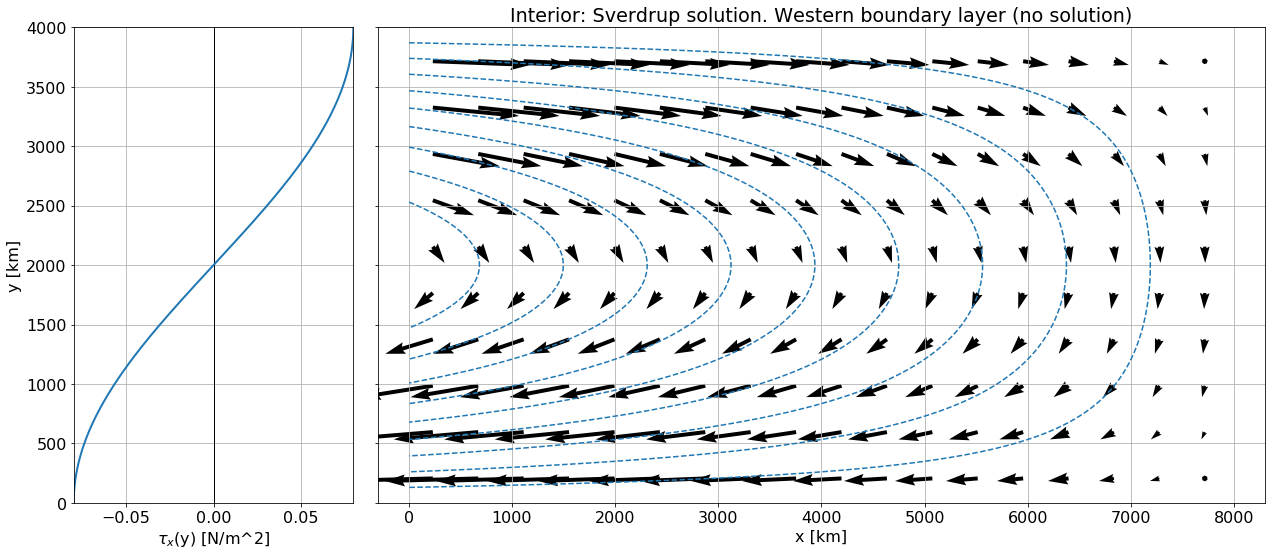

In [3]:
### HERE YOU NEED TO ADJUST TO YOUR NEEDS
western_0  = False                              # Boundary condition: zonal velocity of the interior flow vanishes to the west if "true" (else "false")
eastern_0  = True                            # Boundary condition: zonal velocity of the interior flow vanishes to the east if "true" (else "false")
bottom_drag = False                      # The boundary layer is caused by bottom drag if "true" (else "false") -> Stommel model
lat_frict   = False                           # The boundary layer is caused by lateral friction if "true" (else "false") -> Munk model
drag_coef = 1.*10**(-5)                        # Drag coefficient [s-1]
plot_model(western_0,eastern_0,bottom_drag,lat_frict,drag_coef)     # This line calls the long function defined in the big box above and creates the plot. Nothing to do here.

## a) Second plot (Sverdrup solution with vanishing zonal velocity at Western Boundary):

/Users/ekoehn/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:207: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer


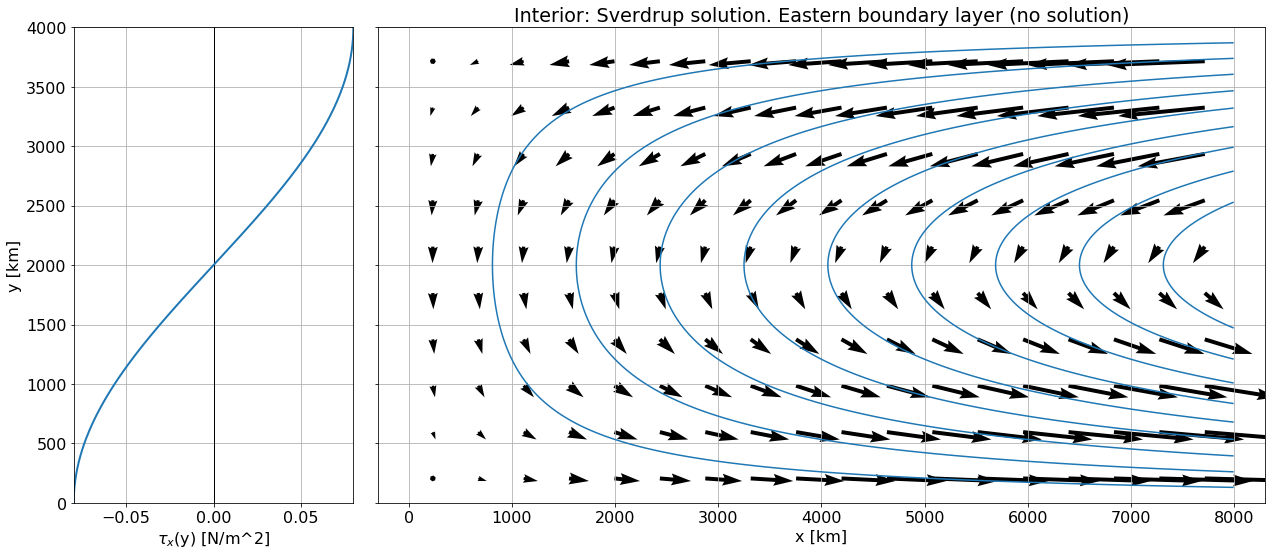

In [4]:
### HERE YOU NEED TO ADJUST TO YOUR NEEDS
western_0  = True                              # Boundary condition: zonal velocity of the interior flow vanishes to the west if "true" (else "false")
eastern_0  = False                            # Boundary condition: zonal velocity of the interior flow vanishes to the east if "true" (else "false")
bottom_drag = False                      # The boundary layer is caused by bottom drag if "true" (else "false") -> Stommel model
lat_frict   = False                           # The boundary layer is caused by lateral friction if "true" (else "false") -> Munk model
drag_coef = 1.*10**(-5)                        # Drag coefficient [s-1]
plot_model(western_0,eastern_0,bottom_drag,lat_frict,drag_coef)

## c) Stommel solution with drag coefficient $r_B = 1\times10^{-5} s^{-1}$

/Users/ekoehn/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:207: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer


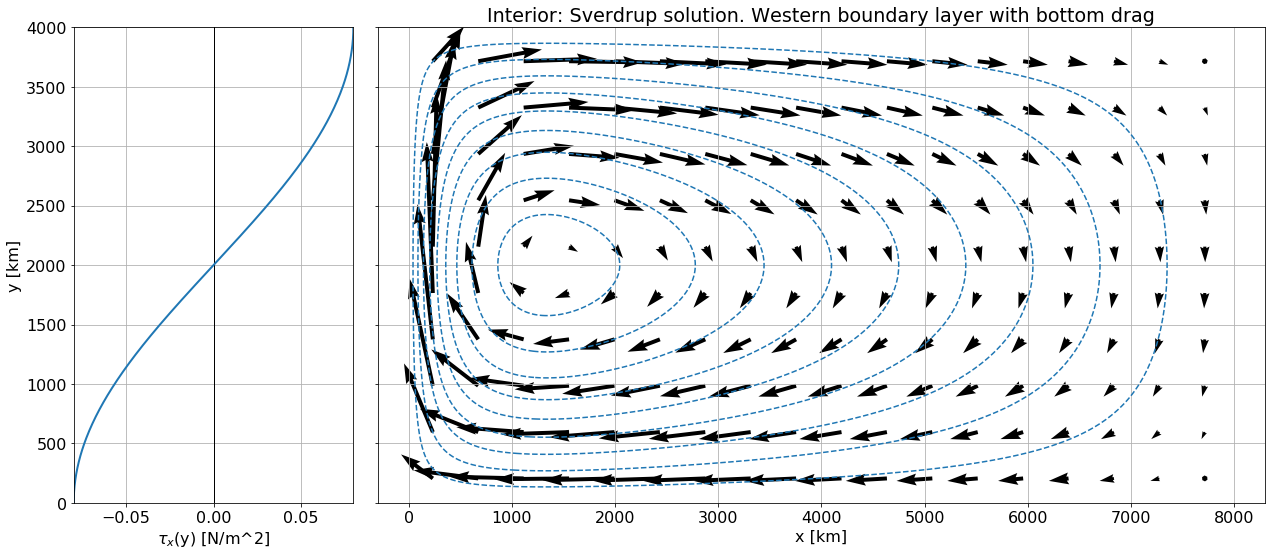

In [5]:
### COPY FROM THE BOX ABOVE AND ADJUST TO YOUR NEEDS
western_0  = False                              # Boundary condition: zonal velocity of the interior flow vanishes to the west if "true" (else "false")
eastern_0  = True                            # Boundary condition: zonal velocity of the interior flow vanishes to the east if "true" (else "false")
bottom_drag = True                      # The boundary layer is caused by bottom drag if "true" (else "false") -> Stommel model
lat_frict   = False                           # The boundary layer is caused by lateral friction if "true" (else "false") -> Munk model
drag_coef = 1.*10**(-5)                        # Drag coefficient [s-1]
plot_model(western_0,eastern_0,bottom_drag,lat_frict,drag_coef)

## c) Stommel solution with drag coefficient  $r_B = \beta*L_s$

drag_coeff r_B = 1.9799999999999997e-06 s-1


/Users/ekoehn/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:207: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer


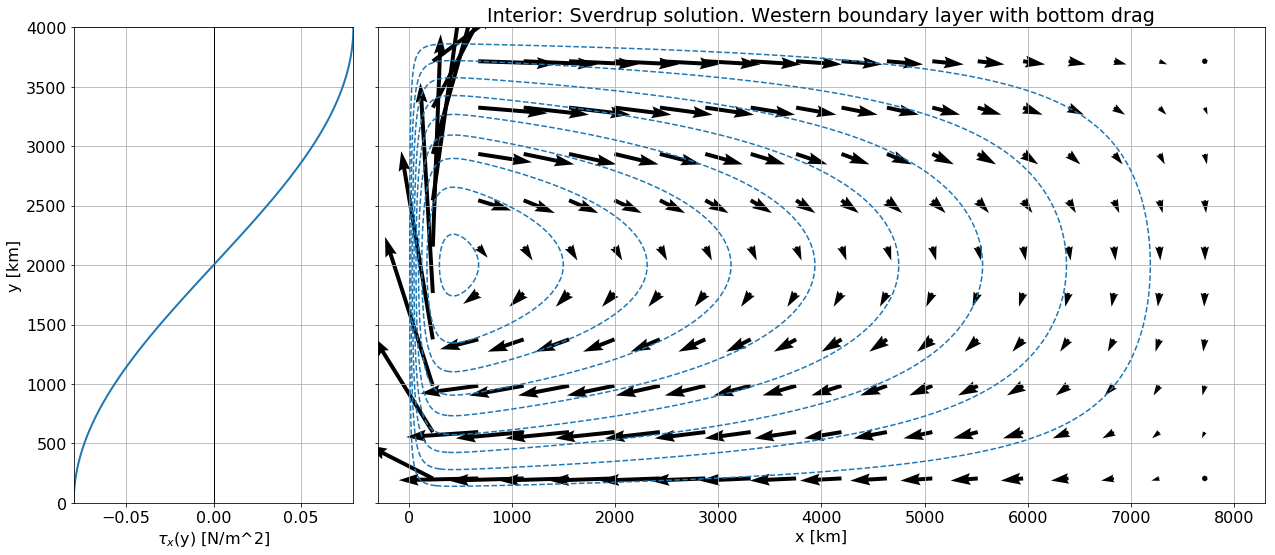

In [6]:
### COPY FROM THE BOX ABOVE AND ADJUST TO YOUR NEEDS
western_0  = False                              # Boundary condition: zonal velocity of the interior flow vanishes to the west if "true" (else "false")
eastern_0  = True                            # Boundary condition: zonal velocity of the interior flow vanishes to the east if "true" (else "false")
bottom_drag = True                      # The boundary layer is caused by bottom drag if "true" (else "false") -> Stommel model
lat_frict   = False                           # The boundary layer is caused by lateral friction if "true" (else "false") -> Munk model
beta = 1.98*10**-11 # s−1 m−1
Ls = 100000 # m
drag_coef = beta*Ls                        # Drag coefficient [s-1]
print('drag_coeff r_B = {} s-1'.format(drag_coef))
plot_model(western_0,eastern_0,bottom_drag,lat_frict,drag_coef)

## c) Stommel solution with drag coefficient $r_B = 1\times10^{-7} s^{-1}$

/Users/ekoehn/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:207: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer


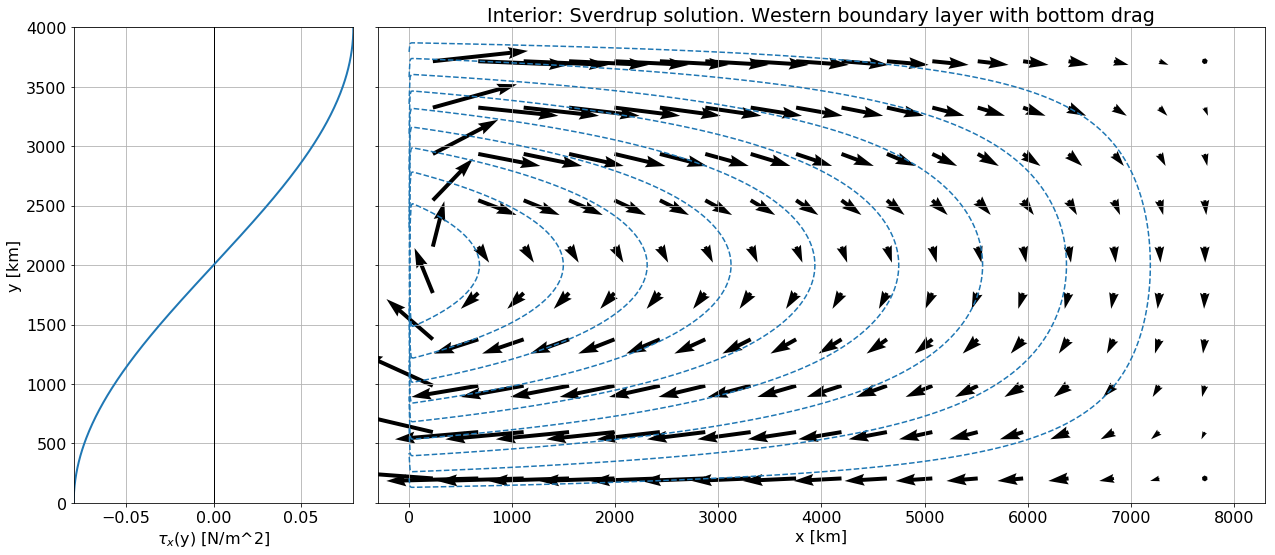

In [7]:
### COPY FROM THE BOX ABOVE AND ADJUST TO YOUR NEEDS
western_0  = False                              # Boundary condition: zonal velocity of the interior flow vanishes to the west if "true" (else "false")
eastern_0  = True                            # Boundary condition: zonal velocity of the interior flow vanishes to the east if "true" (else "false")
bottom_drag = True                      # The boundary layer is caused by bottom drag if "true" (else "false") -> Stommel model
lat_frict   = False                           # The boundary layer is caused by lateral friction if "true" (else "false") -> Munk model
drag_coef = 1.*10**(-7)                        # Drag coefficient [s-1]
plot_model(western_0,eastern_0,bottom_drag,lat_frict,drag_coef)

## c) Munk model

/Users/ekoehn/miniconda3/lib/python3.5/site-packages/ipykernel_launcher.py:207: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer


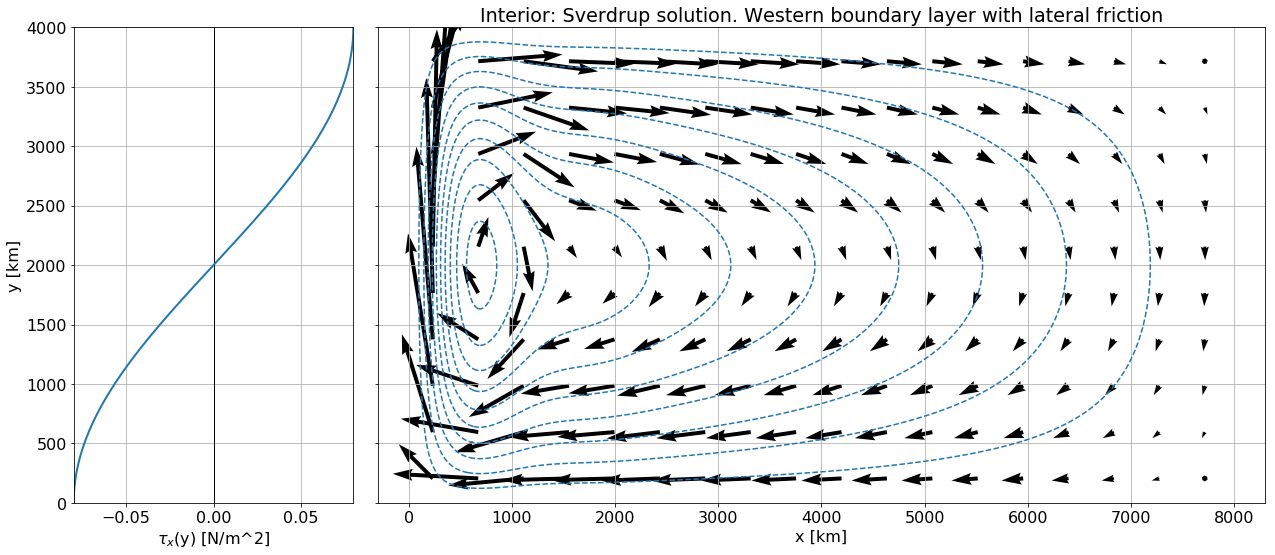

In [8]:
western_0  = False                              # Boundary condition: zonal velocity of the interior flow vanishes to the west if "true" (else "false")
eastern_0  = True                            # Boundary condition: zonal velocity of the interior flow vanishes to the east if "true" (else "false")
bottom_drag = False                      # The boundary layer is caused by bottom drag if "true" (else "false") -> Stommel model
lat_frict   = True                           # The boundary layer is caused by lateral friction if "true" (else "false") -> Munk model
drag_coef = 1.*10**(-7) # Not used                       # Drag coefficient [s-1]
plot_model(western_0,eastern_0,bottom_drag,lat_frict,drag_coef)